# Notebook 02b — Analyse exploratoire et feature importance (OPTIONNEL)

> **Ce notebook est optionnel.** Il ne fait pas partie du pipeline principal (01 → 02a → 03a → 04a → 05a) mais documente l'analyse exploratoire qui a guidé les choix de feature engineering en 03a.

---

## Objectifs

Ce notebook réalise une analyse complète du dataset préparé pour :

1. Comprendre les distributions des variables (analyse univariée)
2. Identifier les relations feature → target (analyse bivariée)
3. Détecter la multicolinéarité entre features (matrice de corrélation)
4. Explorer les patterns temporels (heure, jour, mois)
5. Visualiser les patterns géographiques (carte de France)
6. Entraîner des modèles baseline pour établir des scores de référence
7. Extraire les feature importances avec RandomForest
8. Documenter les décisions pour le feature engineering (03a)

---

Input : dataset_complet_raw.csv (208,616 accidents × 54 colonnes)  
Output : Insights documentés, scores baseline, décisions pour 03a  
Notebook précédent : 02a_preparation_complete.ipynb  
Notebook suivant : 03a_features_intelligentes.ipynb

---

## 1. Configuration et chargement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score
)

# configuration
pd.set_option('display.max_columns', None)

DATA_DIR = Path("../../data")

print("Configuration chargée")

Configuration chargée


In [2]:
# Charger le dataset
df = pd.read_csv(DATA_DIR / 'dataset_complet_raw.csv')
print(f"Dataset chargé : {df.shape}")
print(f"\nColonnes : {df.columns.tolist()}")

Dataset chargé : (208616, 54)

Colonnes : ['Num_Acc', 'annee', 'mois', 'lum', 'dep', 'com', 'agg', 'int', 'atm', 'col', 'lat', 'long', 'heure', 'jour_semaine', 'weekend', 'heure_pointe', 'nuit', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'vma', 'larrout', 'nb_vehicules', 'obs_max', 'obsm_max', 'choc_mode', 'manv_mode', 'catv_velo', 'catv_edp', 'catv_cyclomoteur', 'catv_moto', 'catv_voiture', 'catv_utilitaire', 'catv_poids_lourd', 'catv_bus', 'nb_usagers', 'nb_conducteurs', 'nb_passagers', 'nb_pietons', 'nb_hommes', 'nb_femmes', 'age_moyen', 'age_min', 'age_max', 'trajet_mode', 'secu_mode', 'mortel', 'grave']


In [3]:
# Définir les groupes de colonnes pour l'analyse
cat_cols = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ',
            'obs_max', 'obsm_max', 'choc_mode', 'manv_mode', 'trajet_mode', 'secu_mode']

num_cols = ['lat', 'long', 'heure', 'jour_semaine', 'mois', 'vma', 'nbv', 'larrout',
            'nb_vehicules', 'nb_usagers', 'nb_conducteurs', 'nb_passagers', 'nb_pietons',
            'nb_hommes', 'nb_femmes', 'age_moyen', 'age_min', 'age_max']

bin_cols = ['weekend', 'heure_pointe', 'nuit',
            'catv_velo', 'catv_edp', 'catv_cyclomoteur', 'catv_moto',
            'catv_voiture', 'catv_utilitaire', 'catv_poids_lourd', 'catv_bus']

target_cols = ['mortel', 'grave']

# Colonnes identifiants/métadata (à exclure des analyses)
meta_cols = ['Num_Acc', 'annee', 'dep', 'com']

print(f"Catégorielles : {len(cat_cols)}")
print(f"Numériques    : {len(num_cols)}")
print(f"Binaires      : {len(bin_cols)}")
print(f"Targets       : {len(target_cols)}")
print(f"Métadata   : {len(meta_cols)}")

Catégorielles : 19
Numériques    : 18
Binaires      : 11
Targets       : 2
Métadonnées   : 4


---

## 2. Analyse Univariée

Distribution de chaque variable pour comprendre les data.

### 2.1 Variables cibles

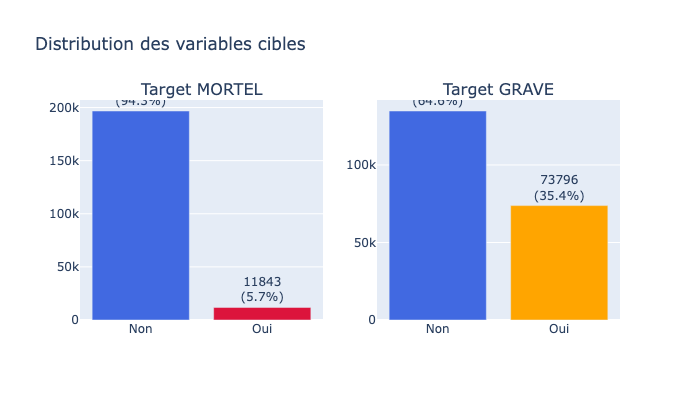

---
ANALYSE DU DÉSÉQUILIBRE DES CLASSES
---

MORTEL : 11843 positifs (5.7%) - Ratio 1:17
GRAVE  : 73796 positifs (35.4%) - Ratio 1:1.8


In [4]:
# distribution des targets
fig = make_subplots(rows=1, cols=2, subplot_titles=['Target MORTEL', 'Target GRAVE'])

for idx, target in enumerate(['mortel', 'grave']):
    counts = df[target].value_counts().sort_index()
    colors = ['royalblue', 'crimson'] if target == 'mortel' else ['royalblue', 'orange']

    fig.add_trace(
        go.Bar(
            x=['Non', 'Oui'],
            y=counts.values,
            marker_color=colors,
            text=[f"{v}<br>({v/len(df)*100:.1f}%)" for v in counts.values],
            textposition='outside'
        ),
        row=1, col=idx+1
    )

fig.update_layout(height=400, showlegend=False, title_text='Distribution des variables cibles')
fig.show()

# calcul des ratios
ratio_mortel = (1 - df['mortel'].mean()) / df['mortel'].mean()
ratio_grave = (1 - df['grave'].mean()) / df['grave'].mean()

print("---")
print("ANALYSE DU DÉSÉQUILIBRE DES CLASSES")
print("---")
print(f"\nMORTEL : {df['mortel'].sum()} positifs ({df['mortel'].mean()*100:.1f}%) - Ratio 1:{ratio_mortel:.0f}")
print(f"GRAVE  : {df['grave'].sum()} positifs ({df['grave'].mean()*100:.1f}%) - Ratio 1:{ratio_grave:.1f}")

### Observation : Implications du déséquilibre

| Target | Taux | Ratio | Conséquence |
|--------|------|-------|-------------|
| mortel | 5.7% | 1:17 | Très déséquilibré → SMOTE probablement nécessaire |
| grave | 35.4% | 1:1.8 | Modérément déséquilibré → class_weight='balanced' suffit |

Note : Ces taux sont calculés après exclusion des 419 usagers avec grav=-1 (cf. 02a, section 3).

Implication pour UC1 : grave est nettement plus simple à modéliser que mortel (pas de SMOTE, plus de cas pour apprendre). Le choix final est documenté dans les notebooks 04a/05a.

### 2.2 Variables numériques

In [5]:
# stats descriptives
print("STATISTIQUES DESCRIPTIVES - Variables numériques")
display(df[num_cols].describe().T.round(2))

STATISTIQUES DESCRIPTIVES - Variables numériques


,count,mean,std,min,25%,50%,75%,max
lat,208616.0,47.09,2.24,41.38,45.26,48.07,48.87,51.08
long,208616.0,2.64,2.55,-5.09,1.46,2.40,4.69,9.55
heure,208616.0,13.48,5.52,0.00,9.00,14.00,18.00,23.00
jour_semaine,208616.0,2.97,1.94,0.00,1.00,3.00,5.00,6.00
mois,208616.0,6.71,3.33,1.00,4.00,7.00,10.00,12.00
vma,208616.0,59.45,22.99,1.00,50.00,50.00,80.00,130.00
nbv,208616.0,2.33,1.23,0.00,2.00,2.00,2.00,12.00
larrout,208616.0,0.50,3.38,-1.00,-1.00,-1.00,-1.00,47.00
nb_vehicules,208616.0,1.71,0.67,1.00,1.00,2.00,2.00,25.00
nb_usagers,208616.0,2.29,1.24,1.00,2.00,2.00,3.00,65.00


### Observation : Problèmes de qualité résiduels

Ces problèmes subsistent dans le dataset produit par 02a :

| Variable | Problème | Traitement 02a | Action restante (03a/04a) |
|----------|----------|----------------|---------------------------|
| larrout | 75% de valeurs -1 (non renseigné) | NaN imputés par médiane | Exclure ou créer larrout_connu |
| nbv | Quelques valeurs -1 | NaN imputés par médiane | Traiter les -1 restants |
| vma | Max = 130 km/h (cohérent après nettoyage 02a) | NaN imputés par médiane (50) | OK, pas d'outlier résiduel |

Rappel 02a : Les colonnes lartpc (99.9% NaN) et occutc (99.1% NaN) ont déjà été supprimées.

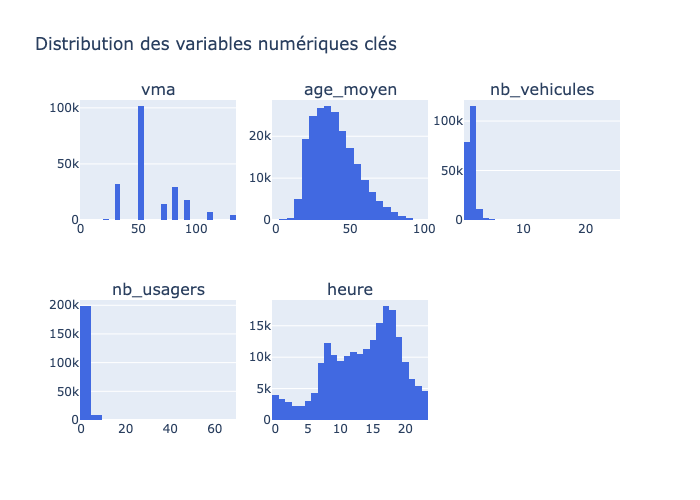

In [6]:
# distributions des principales variables numériques
key_num_cols = ['vma', 'age_moyen', 'nb_vehicules', 'nb_usagers', 'heure']

fig = make_subplots(rows=2, cols=3, subplot_titles=key_num_cols + [''])
positions = [(1,1), (1,2), (1,3), (2,1), (2,2)]

for idx, col in enumerate(key_num_cols):
    row, col_pos = positions[idx]
    fig.add_trace(
        go.Histogram(x=df[col], nbinsx=30, marker_color='royalblue', name=col),
        row=row, col=col_pos
    )

fig.update_layout(height=500, showlegend=False, title_text='Distribution des variables numériques clés')
fig.show()

### 2.3 Variables binaires (types de véhicules)

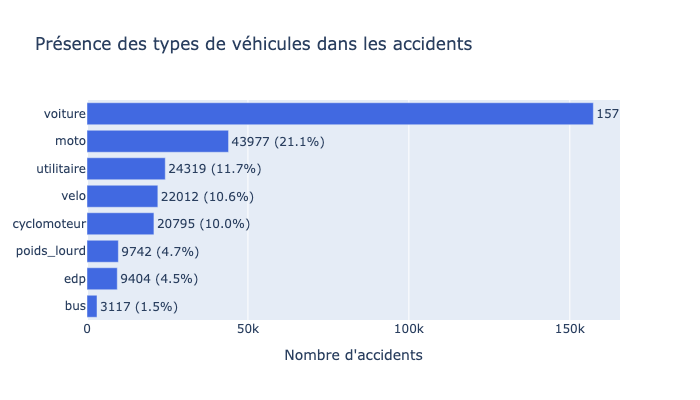


Observation : La voiture est présente dans 82% des accidents.
Les usagers vulnérables (moto, vélo, EDP) représentent une minorité mais sont surreprésentés dans les accidents graves.


In [7]:
# fréquence des types de véhicules
catv_cols = [c for c in bin_cols if c.startswith('catv_')]

catv_freq = df[catv_cols].sum().sort_values(ascending=True)

fig = go.Figure(go.Bar(
    y=catv_freq.index.str.replace('catv_', ''),
    x=catv_freq.values,
    orientation='h',
    marker_color='royalblue',
    text=[f"{v} ({v/len(df)*100:.1f}%)" for v in catv_freq.values],
    textposition='outside'
))

fig.update_layout(
    title_text='Présence des types de véhicules dans les accidents',
    height=400,
    xaxis_title='Nombre d\'accidents'
)
fig.show()

print("\nObservation : La voiture est présente dans 82% des accidents.")
print("Les usagers vulnérables (moto, vélo, EDP) représentent une minorité mais sont surreprésentés dans les accidents graves.")

---

## 3. Analyse Bivariée (Feature → Target)

Relation entre chaque feature et les targets pour identifier les variables prédictives.

### 3.1 Variables catégorielles vs Target

In [8]:
# labels pour interprétation
labels = {
    'lum': {1: 'Jour', 2: 'Crépuscule', 3: 'Nuit sans écl.', 4: 'Nuit écl. éteint', 5: 'Nuit écl. allumé'},
    'agg': {1: 'Hors agglo', 2: 'En agglo'},
    'col': {1: 'Frontale', 2: 'Arrière', 3: 'Côté', 4: 'Chaîne', 5: 'Multiples', 6: 'Autre', 7: 'Sans collision'},
    'catr': {1: 'Autoroute', 2: 'Nationale', 3: 'Départementale', 4: 'Communale', 5: 'Hors réseau', 6: 'Parc'},
    'atm': {1: 'Normale', 2: 'Pluie légère', 3: 'Pluie forte', 4: 'Neige', 5: 'Brouillard', 6: 'Vent fort', 7: 'Éblouissant', 8: 'Couvert'},
    'surf': {1: 'Normale', 2: 'Mouillée', 3: 'Flaques', 4: 'Inondée', 5: 'Enneigée', 6: 'Boue', 7: 'Verglacée', 8: 'Huile', 9: 'Autre'}
}

# analyse une variable catégorielle vs target
def analyse_cat_vs_target(col, target='mortel'):
    analyse = df.groupby(col).agg(
        n=('mortel', 'count'),
        taux_mortel=('mortel', 'mean'),
        taux_grave=('grave', 'mean')
    ).reset_index()

    analyse['taux_mortel'] = analyse['taux_mortel'] * 100
    analyse['taux_grave'] = analyse['taux_grave'] * 100

    if col in labels:
        analyse['label'] = analyse[col].map(labels[col]).fillna(analyse[col].astype(str))
    else:
        analyse['label'] = analyse[col].astype(str)

    return analyse.sort_values(f'taux_{target}', ascending=False)

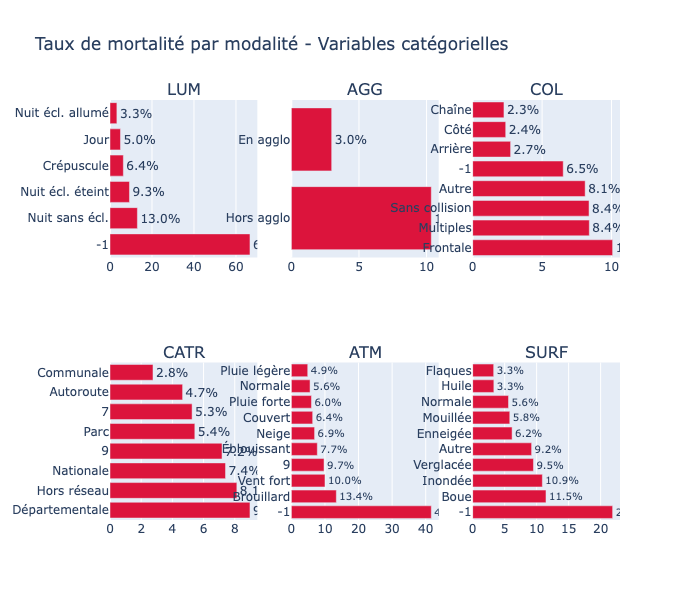

In [9]:
# analyse des 6 variables catégorielles principales
top_cat = ['lum', 'agg', 'col', 'catr', 'atm', 'surf']

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[c.upper() for c in top_cat]
)

positions = [(1,1), (1,2), (1,3), (2,1), (2,2), (2,3)]

for idx, col in enumerate(top_cat):
    row, col_pos = positions[idx]
    analyse = analyse_cat_vs_target(col)

    fig.add_trace(
        go.Bar(
            y=analyse['label'],
            x=analyse['taux_mortel'],
            orientation='h',
            marker_color='crimson',
            text=analyse['taux_mortel'].apply(lambda x: f'{x:.1f}%'),
            textposition='outside',
            showlegend=False
        ),
        row=row, col=col_pos
    )

fig.update_layout(
    title_text='Taux de mortalité par modalité - Variables catégorielles',
    height=600,
    showlegend=False
)
fig.show()

### Observations - Variables catégorielles à fort impact

| Variable | Modalité à risque | Taux mortel | Interprétation |
|----------|-------------------|-------------|----------------|
| lum | Nuit sans éclairage | ~13% | Visibilité nulle |
| agg | Hors agglomération | ~11% | Vitesse + délai secours |
| col | Collision frontale | ~11% | Impact maximal |
| catr | Route départementale | ~9.5% | Routes sinueuses, vitesse élevée |

Surprise : L'autoroute est moins mortelle que la départementale (infrastructures de sécurité, séparation des voies).

### 3.2 Variables numériques et binaires vs Target (corrélations)

In [10]:
# corrélations avec les targets
features_for_corr = [c for c in num_cols + bin_cols if c in df.columns]

correlations = pd.DataFrame({
    'feature': features_for_corr,
    'corr_mortel': [df[c].corr(df['mortel']) for c in features_for_corr],
    'corr_grave': [df[c].corr(df['grave']) for c in features_for_corr]
})

correlations['abs_corr'] = correlations['corr_mortel'].abs()
correlations = correlations.sort_values('abs_corr', ascending=False)

# affichage
print("CORRÉLATIONS AVEC LES TARGETS")
print("Feature / MORTEL / GRAVE")
for _, row in correlations.head(15).iterrows():
    feat = row['feature']
    print(f"  {feat}: mortel={row['corr_mortel']:+.3f}, grave={row['corr_grave']:+.3f}")

CORRÉLATIONS AVEC LES TARGETS
Feature / MORTEL / GRAVE
  vma: mortel=+0.125, grave=+0.201
  age_min: mortel=+0.103, grave=+0.120
  age_moyen: mortel=+0.100, grave=+0.115
  catv_poids_lourd: mortel=+0.090, grave=+0.048
  age_max: mortel=+0.073, grave=+0.081
  larrout: mortel=+0.068, grave=+0.140
  nb_conducteurs: mortel=-0.066, grave=-0.130
  nb_vehicules: mortel=-0.065, grave=-0.129
  catv_cyclomoteur: mortel=-0.050, grave=-0.016
  lat: mortel=-0.049, grave=-0.168
  nuit: mortel=+0.041, grave=+0.015
  catv_edp: mortel=-0.037, grave=-0.072
  nb_femmes: mortel=-0.035, grave=-0.047
  heure_pointe: mortel=-0.035, grave=-0.037
  catv_voiture: mortel=-0.034, grave=-0.056


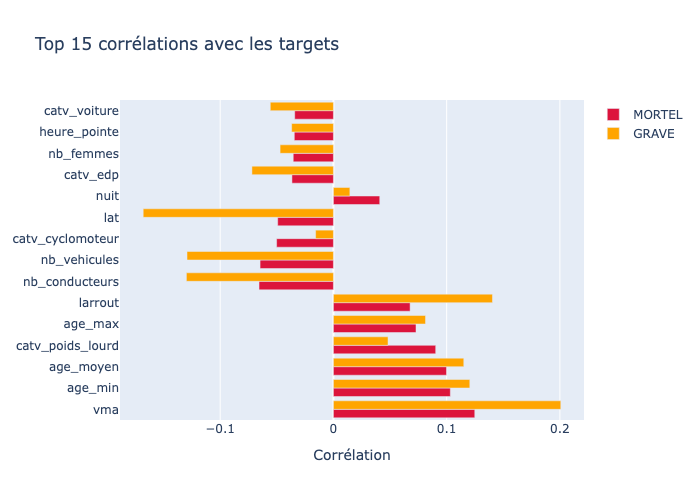

In [11]:
# visualisation des corrélations
fig = go.Figure()

top_corr = correlations.head(15)

fig.add_trace(go.Bar(
    name='MORTEL',
    y=top_corr['feature'],
    x=top_corr['corr_mortel'],
    orientation='h',
    marker_color='crimson'
))

fig.add_trace(go.Bar(
    name='GRAVE',
    y=top_corr['feature'],
    x=top_corr['corr_grave'],
    orientation='h',
    marker_color='orange'
))

fig.update_layout(
    title_text='Top 15 corrélations avec les targets',
    barmode='group',
    height=500,
    xaxis_title='Corrélation'
)
fig.show()

### Observations - Corrélations

Corrélations positives (augmentent la gravité) :
- vma : Plus la vitesse autorisée est élevée, plus c'est grave
- age_* : Personnes âgées plus vulnérables
- catv_poids_lourd : Masse = impact violent
- nuit : Conditions de visibilité dégradées

Corrélations négatives (réduisent la gravité) :
- nb_vehicules : Plus de véhicules = embouteillage = faible vitesse
- catv_cyclomoteur : Faible vitesse
- heure_pointe : Trafic dense = vitesse réduite

---

## 4. Analyse de la Multicolinéarité

Détecter les features redondantes qui pourraient causer des problèmes de modélisation.

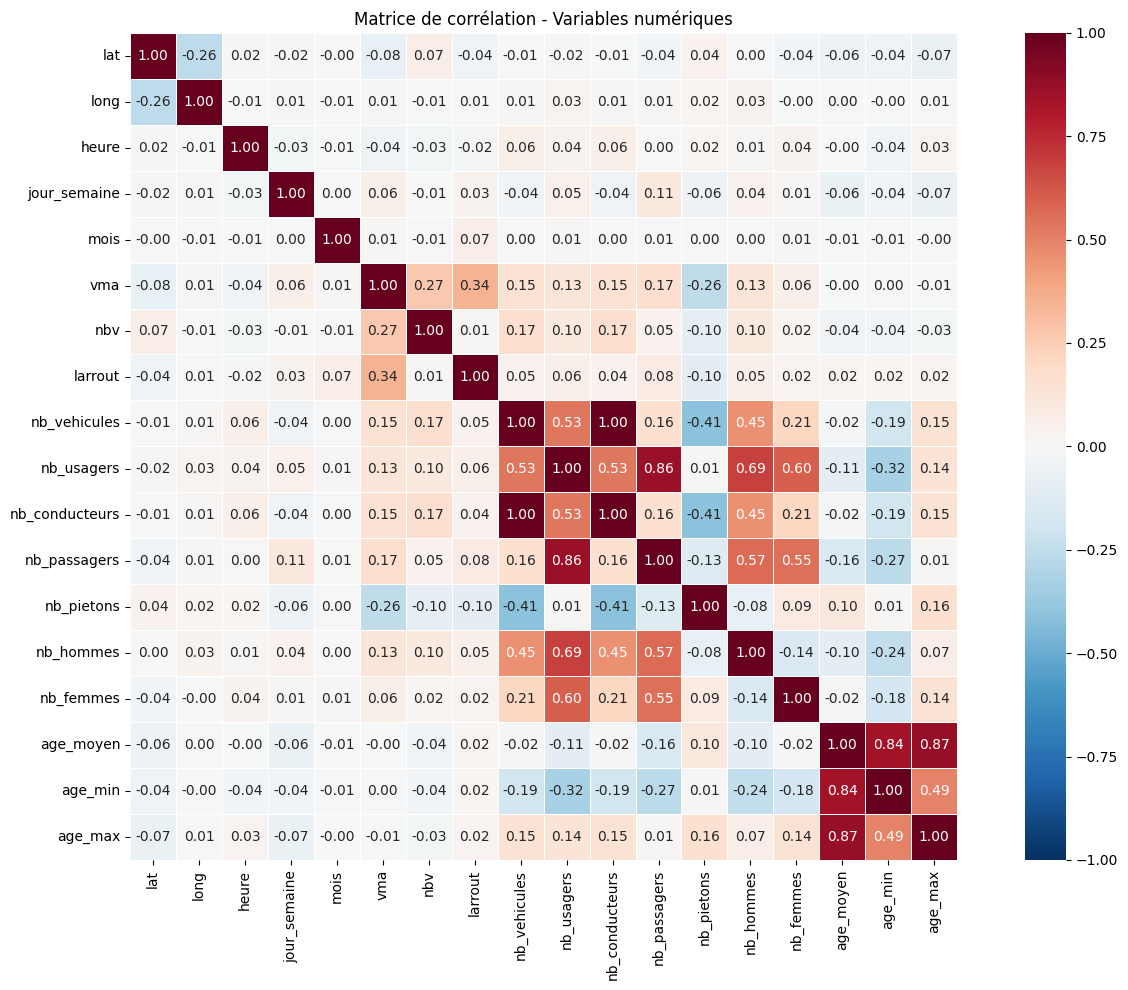

In [12]:
# Matrice de corrélation des features numériques
corr_matrix = df[num_cols].corr()

# Heatmap (seaborn pour rendu statique rapide)
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True, fmt='.2f',
    cmap='RdBu_r',
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=0.5
)
plt.title('Matrice de corrélation - Variables numériques')
plt.tight_layout()
plt.show()

In [13]:
# paires fortement corrélées (|r| > 0.7)
print("PAIRES FORTEMENT CORRÉLÉES (|r| > 0.7)")

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.7:
            high_corr_pairs.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': corr
            })

if high_corr_pairs:
    for pair in sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True):
        print(f"  {pair['var1']} / {pair['var2']}: {pair['correlation']:.3f}")
else:
    print("  Aucune paire avec |r| > 0.7")

PAIRES FORTEMENT CORRÉLÉES (|r| > 0.7)
  nb_vehicules / nb_conducteurs: 0.998
  age_moyen / age_max: 0.871
  nb_usagers / nb_passagers: 0.863
  age_moyen / age_min: 0.843


### Décisions - Multicolinéarité

| Paire corrélée | Corrélation | Décision | Justification |
|----------------|-------------|----------|---------------|
| nb_vehicules ↔ nb_conducteurs | ~0.998 | Supprimer nb_conducteurs | Quasi-identiques (1 véhicule = 1 conducteur) |
| nb_usagers ↔ nb_passagers | ~0.86 | Supprimer nb_passagers | nb_usagers plus général |
| age_moyen ↔ age_min/age_max | ~0.84/0.87 | Supprimer age_min, age_max | age_moyen suffit |

Impact : Ces suppressions évitent l'instabilité des modèles linéaires et le choix arbitraire dans les arbres.

---

## 5. Patterns Temporels

Analyse des variations de gravité selon l'heure, le jour et le mois.

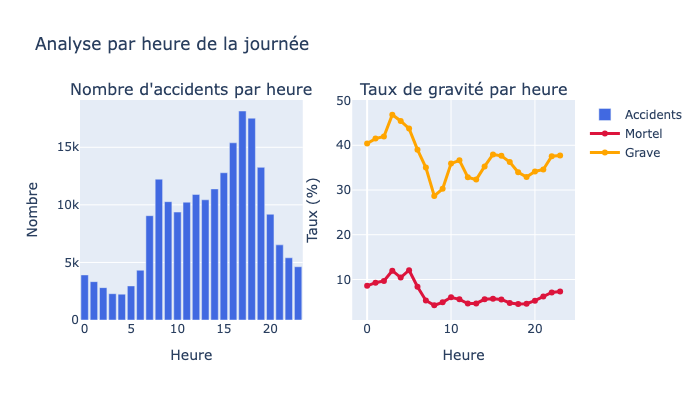

In [14]:
# taux de mortalité par heure
hourly = df.groupby('heure').agg(
    n_accidents=('mortel', 'count'),
    taux_mortel=('mortel', 'mean'),
    taux_grave=('grave', 'mean')
).reset_index()

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Nombre d\'accidents par heure', 'Taux de gravité par heure']
)

# volume
fig.add_trace(
    go.Bar(x=hourly['heure'], y=hourly['n_accidents'], marker_color='royalblue', name='Accidents'),
    row=1, col=1
)

# taux
fig.add_trace(
    go.Scatter(x=hourly['heure'], y=hourly['taux_mortel']*100, mode='lines+markers',
               marker_color='crimson', name='Mortel', line=dict(width=3)),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=hourly['heure'], y=hourly['taux_grave']*100, mode='lines+markers',
               marker_color='orange', name='Grave', line=dict(width=3)),
    row=1, col=2
)

fig.update_layout(height=400, title_text='Analyse par heure de la journée')
fig.update_xaxes(title_text='Heure', row=1, col=1)
fig.update_xaxes(title_text='Heure', row=1, col=2)
fig.update_yaxes(title_text='Nombre', row=1, col=1)
fig.update_yaxes(title_text='Taux (%)', row=1, col=2)
fig.show()

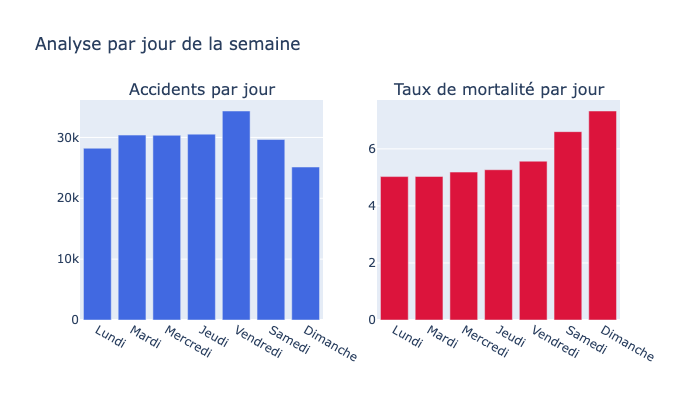

In [15]:
# taux par jour de la semaine
jours = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

daily = df.groupby('jour_semaine').agg(
    n_accidents=('mortel', 'count'),
    taux_mortel=('mortel', 'mean'),
    taux_grave=('grave', 'mean')
).reset_index()

daily['jour'] = daily['jour_semaine'].map(lambda x: jours[x])

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Accidents par jour', 'Taux de mortalité par jour']
)

fig.add_trace(
    go.Bar(x=daily['jour'], y=daily['n_accidents'], marker_color='royalblue'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=daily['jour'], y=daily['taux_mortel']*100, marker_color='crimson'),
    row=1, col=2
)

fig.update_layout(height=400, showlegend=False, title_text='Analyse par jour de la semaine')
fig.show()

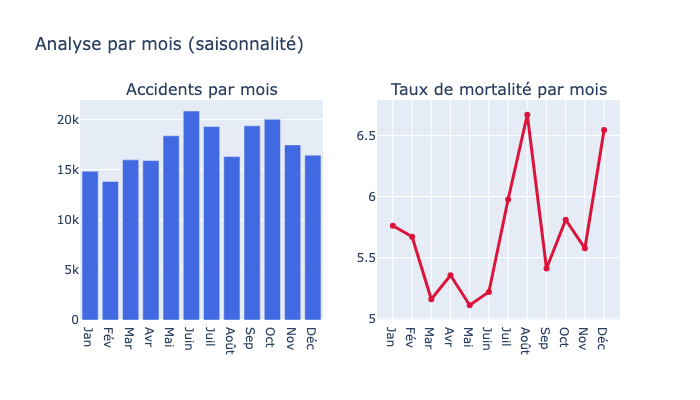

In [16]:
# taux par mois (saisonnalité)
mois_noms = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']

monthly = df.groupby('mois').agg(
    n_accidents=('mortel', 'count'),
    taux_mortel=('mortel', 'mean'),
    taux_grave=('grave', 'mean')
).reset_index()

monthly['mois_nom'] = monthly['mois'].map(lambda x: mois_noms[int(x)-1])

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Accidents par mois', 'Taux de mortalité par mois']
)

fig.add_trace(
    go.Bar(x=monthly['mois_nom'], y=monthly['n_accidents'], marker_color='royalblue'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=monthly['mois_nom'], y=monthly['taux_mortel']*100, mode='lines+markers',
               marker_color='crimson', line=dict(width=3)),
    row=1, col=2
)

fig.update_layout(height=400, showlegend=False, title_text='Analyse par mois (saisonnalité)')
fig.show()

### Observations - Patterns temporels

Par heure :
- Volume max : 17h-18h (heure de pointe)
- Taux mortel max : 4h-6h du matin (~12%) → fatigue, alcool, vitesse
- Paradoxe : moins d'accidents la nuit mais plus graves

Par jour :
- Plus d'accidents le vendredi (départs week-end)
- Taux mortel plus élevé samedi/dimanche → routes secondaires, vitesse, alcool

Par mois :
- Plus d'accidents en été (juin-septembre)
- Taux de mortalité relativement stable

→ Feature à créer : heure_danger (2h-6h) avec taux de mortalité ~12%

---

## 6. Patterns Géographiques

/var/folders/5q/1z0_7_dd4559pfbhnn6y1dj80000gp/T/ipykernel_70950/555786938.py:4: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



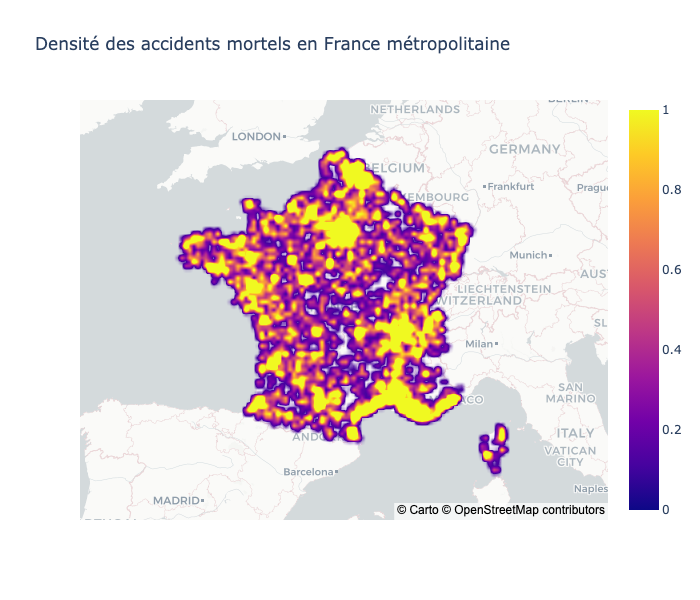

In [17]:
# Carte de densité des accidents mortels
df_mortels = df[df['mortel'] == 1].sample(min(5000, df['mortel'].sum()), random_state=42)

fig = px.density_mapbox(
    df_mortels,
    lat='lat',
    lon='long',
    radius=5,
    center=dict(lat=46.5, lon=2.5),
    zoom=4,
    mapbox_style='carto-positron',
    title='Densité des accidents mortels en France métropolitaine'
)

fig.update_layout(height=600)
fig.show()

In [18]:
# analyse par zone géographique (latitude)
df['zone_lat'] = pd.cut(df['lat'], bins=[41, 44, 46, 48, 52], labels=['Sud', 'Centre-Sud', 'Centre-Nord', 'Nord'])

zone_analysis = df.groupby('zone_lat').agg(
    n_accidents=('mortel', 'count'),
    taux_mortel=('mortel', 'mean'),
    taux_grave=('grave', 'mean')
).reset_index()

print("ANALYSE PAR ZONE GÉOGRAPHIQUE")
for _, row in zone_analysis.iterrows():
    print(f"  {row['zone_lat']}: {row['n_accidents']} accidents, {row['taux_mortel']*100:.1f}% mortels, {row['taux_grave']*100:.1f}% graves")

ANALYSE PAR ZONE GÉOGRAPHIQUE
  Sud: 35685 accidents, 6.7% mortels, 44.2% graves
  Centre-Sud: 35615 accidents, 7.0% mortels, 44.9% graves
  Centre-Nord: 31304 accidents, 8.7% mortels, 49.7% graves
  Nord: 106012 accidents, 4.0% mortels, 25.0% graves


/var/folders/5q/1z0_7_dd4559pfbhnn6y1dj80000gp/T/ipykernel_70950/315561836.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Observations - Géographie

Zones à forte densité d'accidents :
- Île-de-France (volume)
- Grandes métropoles (Lyon, Marseille, Bordeaux)

Zones à fort taux de mortalité :
- Zones rurales (routes départementales, délai d'arrivée des secours)
- Sud-Ouest, Centre

Décision pour UC1 : Ne pas utiliser lat/long directement (non causal, overfitting). Utiliser dep comme proxy géographique plus robuste.

---

## 7. Modèles Baseline

Établir des scores de référence à battre avec des modèles simples.

Note méthodologique : Les baselines ci-dessous utilisent un split aléatoire 80/20 (rapide pour l'exploration). La modélisation finale (05a) utilise un split temporel (train 2021-2023, test 2024) pour une évaluation réaliste en conditions de production. Les scores ici sont donc légèrement optimistes par rapport au pipeline final.

In [19]:
# Préparer les data pour les modèles
# Exclure les colonnes non numériques et les métadata
exclude_cols = ['Num_Acc', 'annee', 'dep', 'com', 'mortel', 'grave', 'zone_lat']
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Ne garder que les colonnes numériques
X = df[feature_cols].select_dtypes(include=[np.number])
y_mortel = df['mortel']
y_grave = df['grave']

# Supprimer les colonnes redondantes identifiées
cols_to_drop = ['nb_conducteurs', 'age_min', 'age_max', 'nb_passagers']
X = X.drop(columns=[c for c in cols_to_drop if c in X.columns], errors='ignore')

print(f"Features pour modélisation : {X.shape[1]}")
print(f"Colonnes : {X.columns.tolist()}")

Features pour modélisation : 44
Colonnes : ['mois', 'lum', 'agg', 'int', 'atm', 'col', 'lat', 'long', 'heure', 'jour_semaine', 'weekend', 'heure_pointe', 'nuit', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'vma', 'larrout', 'nb_vehicules', 'obs_max', 'obsm_max', 'choc_mode', 'manv_mode', 'catv_velo', 'catv_edp', 'catv_cyclomoteur', 'catv_moto', 'catv_voiture', 'catv_utilitaire', 'catv_poids_lourd', 'catv_bus', 'nb_usagers', 'nb_pietons', 'nb_hommes', 'nb_femmes', 'age_moyen', 'trajet_mode', 'secu_mode']


In [20]:
# split train/test (même indices pour les deux targets)
X_train, X_test, y_train_mortel, y_test_mortel = train_test_split(
    X, y_mortel, test_size=0.2, random_state=42, stratify=y_mortel
)

# récupérer les mêmes indices pour grave
y_train_grave = y_grave.iloc[y_train_mortel.index]
y_test_grave = y_grave.iloc[y_test_mortel.index]

print(f"Train : {len(X_train)} ({len(X_train)/len(X)*100:.0f}%)")
print(f"Test  : {len(X_test)} ({len(X_test)/len(X)*100:.0f}%)")
print(f"\nTaux MORTEL - Train: {y_train_mortel.mean()*100:.1f}% | Test: {y_test_mortel.mean()*100:.1f}%")
print(f"Taux GRAVE  - Train: {y_train_grave.mean()*100:.1f}% | Test: {y_test_grave.mean()*100:.1f}%")

Train : 166892 (80%)
Test  : 41724 (20%)

Taux MORTEL - Train: 5.7% | Test: 5.7%
Taux GRAVE  - Train: 35.4% | Test: 35.3%


### 7.1 Baseline naïf

In [21]:
print("BASELINE NAÏF (prédire toujours la classe majoritaire)")

for target_name, y_train, y_test in [('MORTEL', y_train_mortel, y_test_mortel),
                                       ('GRAVE', y_train_grave, y_test_grave)]:
    dummy = DummyClassifier(strategy='most_frequent')
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)

    print(f"\n{target_name}:")
    print(f"  Accuracy  : {(y_pred == y_test).mean()*100:.1f}%")
    print(f"  Precision : {precision_score(y_test, y_pred, zero_division=0)*100:.1f}%")
    print(f"  Recall    : {recall_score(y_test, y_pred)*100:.1f}%")
    print("  Ce baseline est INUTILE (prédit toujours 0)")

BASELINE NAÏF (prédire toujours la classe majoritaire)

MORTEL:
  Accuracy  : 94.3%
  Precision : 0.0%
  Recall    : 0.0%
  Ce baseline est INUTILE (prédit toujours 0)

GRAVE:
  Accuracy  : 64.7%
  Precision : 0.0%
  Recall    : 0.0%
  Ce baseline est INUTILE (prédit toujours 0)


### 7.2 Logistic Regression

In [22]:
# standardiser pour logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("LOGISTIC REGRESSION (avec class_weight='balanced')")

baseline_scores = {}

for target_name, y_train, y_test in [('MORTEL', y_train_mortel, y_test_mortel),
                                       ('GRAVE', y_train_grave, y_test_grave)]:
    lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    lr.fit(X_train_scaled, y_train)

    y_pred = lr.predict(X_test_scaled)
    y_proba = lr.predict_proba(X_test_scaled)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    baseline_scores[f"{target_name}_LR"] = {
        'model': 'LogisticRegression',
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    print(f"\n{target_name}:")
    print(f"  ROC-AUC   : {roc_auc:.3f}")
    print(f"  Precision : {precision*100:.1f}%")
    print(f"  Recall    : {recall*100:.1f}%")
    print(f"  F1-Score  : {f1:.3f}")

LOGISTIC REGRESSION (avec class_weight='balanced')

MORTEL:
  ROC-AUC   : 0.790
  Precision : 13.4%
  Recall    : 72.1%
  F1-Score  : 0.226

GRAVE:
  ROC-AUC   : 0.754
  Precision : 56.4%
  Recall    : 67.0%
  F1-Score  : 0.613


### 7.3 RandomForest

In [23]:
print("RANDOM FOREST (avec class_weight='balanced')")

rf_models = {}

for target_name, y_train, y_test in [('MORTEL', y_train_mortel, y_test_mortel),
                                       ('GRAVE', y_train_grave, y_test_grave)]:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    rf_models[target_name] = rf

    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    baseline_scores[f"{target_name}_RF"] = {
        'model': 'RandomForest',
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    print(f"\n{target_name}:")
    print(f"  ROC-AUC   : {roc_auc:.3f}")
    print(f"  Precision : {precision*100:.1f}%")
    print(f"  Recall    : {recall*100:.1f}%")
    print(f"  F1-Score  : {f1:.3f}")

RANDOM FOREST (avec class_weight='balanced')

MORTEL:
  ROC-AUC   : 0.832
  Precision : 15.7%
  Recall    : 73.1%
  F1-Score  : 0.258

GRAVE:
  ROC-AUC   : 0.817
  Precision : 62.9%
  Recall    : 72.7%
  F1-Score  : 0.675


### Résumé des scores baseline (split aléatoire 80/20)

| Target | Modèle | ROC-AUC | Precision | Recall | F1 |
|--------|--------|---------|-----------|--------|----|
| MORTEL | LogReg | 0.790 | 13.4% | 72.1% | 0.226 |
| MORTEL | RF | 0.832 | 15.7% | 73.1% | 0.258 |
| GRAVE | LogReg | 0.754 | 56.4% | 67.0% | 0.613 |
| GRAVE | RF | 0.817 | 62.9% | 72.7% | 0.675 |

Observations clés :
- La precision pour MORTEL (~16%) est très faible à cause du déséquilibre 1:17
- Pour GRAVE, la precision atteint 63% avec RF — nettement plus exploitable
- Le RandomForest surpasse LogisticRegression sur les deux targets (+0.04 à +0.06 ROC-AUC)

Rappel : Ces scores sont obtenus avec un split aléatoire. Le split temporel (05a) donnera des scores légèrement inférieurs mais plus réalistes.

---

## 8. Feature Importance (RandomForest)

Identifier les features les plus prédictives pour chaque target.

In [24]:
# extraire et trier les feature importances
def get_feature_importance(model, feature_names, top_n=20):
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    return importance.head(top_n)

# feature importance pour les deux targets
fi_mortel = get_feature_importance(rf_models['MORTEL'], X.columns, top_n=20)
fi_grave = get_feature_importance(rf_models['GRAVE'], X.columns, top_n=20)

print("TOP 15 FEATURES - MORTEL")
for _, row in fi_mortel.head(15).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

TOP 15 FEATURES - MORTEL
  agg: 0.101
  vma: 0.097
  age_moyen: 0.079
  lat: 0.072
  catr: 0.059
  col: 0.057
  obs_max: 0.052
  obsm_max: 0.045
  long: 0.040
  catv_poids_lourd: 0.034
  circ: 0.032
  situ: 0.027
  nb_vehicules: 0.024
  trajet_mode: 0.023
  secu_mode: 0.022


In [25]:
print("\nTOP 15 FEATURES - GRAVE")
for _, row in fi_grave.head(15).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")


TOP 15 FEATURES - GRAVE
  lat: 0.174
  vma: 0.100
  catr: 0.095
  long: 0.091
  agg: 0.089
  larrout: 0.052
  nbv: 0.047
  circ: 0.041
  obsm_max: 0.037
  col: 0.037
  age_moyen: 0.032
  obs_max: 0.028
  situ: 0.021
  trajet_mode: 0.021
  catv_moto: 0.016


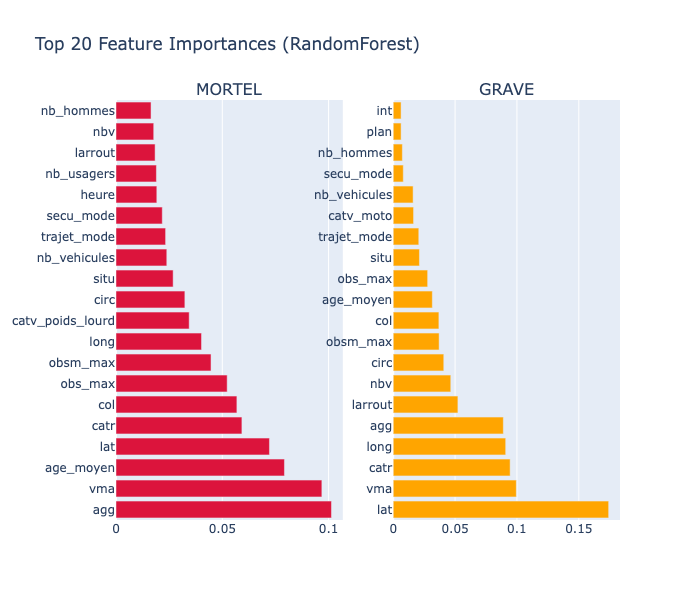

In [26]:
# visualisation comparative
fig = make_subplots(rows=1, cols=2, subplot_titles=['MORTEL', 'GRAVE'])

fig.add_trace(
    go.Bar(
        y=fi_mortel['feature'],
        x=fi_mortel['importance'],
        orientation='h',
        marker_color='crimson'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        y=fi_grave['feature'],
        x=fi_grave['importance'],
        orientation='h',
        marker_color='orange'
    ),
    row=1, col=2
)

fig.update_layout(
    title_text='Top 20 Feature Importances (RandomForest)',
    height=600,
    showlegend=False
)
fig.show()

In [27]:
# comparaison mortel vs grave
comparison = fi_mortel[['feature', 'importance']].rename(columns={'importance': 'imp_mortel'})
comparison = comparison.merge(
    fi_grave[['feature', 'importance']].rename(columns={'importance': 'imp_grave'}),
    on='feature',
    how='outer'
).fillna(0)

comparison['diff'] = comparison['imp_mortel'] - comparison['imp_grave']

print("FEATURES PLUS IMPORTANTES POUR MORTEL QUE GRAVE")
mortel_specific = comparison[comparison['diff'] > 0.005].sort_values('diff', ascending=False)
for _, row in mortel_specific.head(8).iterrows():
    print(f"  {row['feature']}: +{row['diff']:.3f}")

print("\nFEATURES PLUS IMPORTANTES POUR GRAVE QUE MORTEL")
grave_specific = comparison[comparison['diff'] < -0.005].sort_values('diff')
for _, row in grave_specific.head(8).iterrows():
    print(f"  {row['feature']}: {row['diff']:.3f}")

FEATURES PLUS IMPORTANTES POUR MORTEL QUE GRAVE
  age_moyen: +0.048
  catv_poids_lourd: +0.034
  obs_max: +0.024
  col: +0.020
  heure: +0.019
  nb_usagers: +0.019
  secu_mode: +0.014
  agg: +0.012

FEATURES PLUS IMPORTANTES POUR GRAVE QUE MORTEL
  lat: -0.102
  long: -0.051
  catr: -0.035
  larrout: -0.034
  nbv: -0.029
  catv_moto: -0.016
  circ: -0.008
  plan: -0.006


---

## 9. Conclusions et Décisions pour le Feature Engineering

Synthèse de toutes les analyses pour guider le notebook 03a.

### 9.1 Features les plus prédictives (à conserver)

| Rang | Feature | Importance (mortel / grave) | Disponible UC1 ? | Commentaire |
|------|---------|----------------------------|------------------|-------------|
| 1 | agg | 0.101 / 0.089 |  Oui | Rural = vitesse + délai secours |
| 2 | vma | 0.097 / 0.100 |  Oui | Vitesse autorisée = proxy de dangerosité |
| 3 | age_moyen | 0.079 / 0.032 |  Estimable | Seniors vulnérables |
| 4 | catr | 0.059 / 0.095 |  Oui | Type de route |
| 5 | col | 0.057 / 0.037 |  Si décrit | Type de collision |
| 6 | catv_poids_lourd | 0.034 / — |  Oui | Masse = impact violent |

Cas particulier : lat/long

lat est la feature #1 pour GRAVE (importance 0.174) et #4 pour MORTEL (0.072). Malgré cette importance élevée, elle sera exclue de UC1 :
- Non causale : la latitude ne cause pas la gravité
- Proxy de variables déjà capturées (agg, catr, vma)
- Risque d'overfitting géographique (le modèle apprendrait des hotspots plutôt que des patterns généralisables)
- Alternative retenue : dep comme proxy géographique robuste (cf. 04a)

### 9.2 Features à supprimer (multicolinéarité)

| Feature à supprimer | Corrélée avec | Corrélation | Justification |
|---------------------|---------------|-------------|---------------|
| nb_conducteurs | nb_vehicules | 0.998 | Quasi-identiques |
| nb_passagers | nb_usagers | 0.863 | Redondant |
| age_min | age_moyen | 0.843 | age_moyen suffit |
| age_max | age_moyen | 0.871 | age_moyen suffit |

### 9.3 Features à exclure pour UC1 (temps réel)

Ces features ne sont pas disponibles au moment de l'appel des secours :

| Feature | Raison | Alternative |
|---------|--------|-------------|
| obs_max, obsm_max | Obstacles constatés après l'accident | Exclure |
| choc_mode, manv_mode | Analyse post-accident | Exclure |
| secu_mode | Équipements = constat sur place | Exclure |
| trajet_mode | Motif = interrogatoire | Exclure |
| nb_usagers, nb_pietons exact | Comptage complet sur place | Estimer |
| lat, long | Non causal, overfitting | Utiliser dep |

### 9.4 Nouvelles features à créer (03a)

| Feature | Définition | Justification |
|---------|------------|---------------|
| heure_danger | heure ∈ [2, 6] | Pic de mortalité à 12% |
| nuit_hors_agglo | nuit=1 AND agg=1 | Interaction forte |
| meteo_degradee | atm ∈ {2,3,4,5,6} | Pluie, neige, brouillard, vent |
| surface_glissante | surf ∈ {2,3,4,5,7} | Mouillée, verglacée, enneigée |
| collision_asymetrique | poids_lourd × (moto OU vélo) | Choc inégal |
| weekend_nuit | weekend=1 AND nuit=1 | Alcool, vitesse |

### 9.5 Scores baseline à battre

| Target | Métrique | Baseline RF (split aléatoire) | Objectif (split temporel, 05a) |
|--------|----------|-------------------------------|-------------------------------|
| grave (UC1) | ROC-AUC | 0.82 | > 0.83 |
| grave (UC1) | Recall | 72% | > 80% |
| grave (UC1) | F1 | 0.67 | > 0.70 |

Note : Le split temporel utilisé en 05a donnera des scores légèrement inférieurs à ces baselines en split aléatoire. L'objectif tient compte de cet écart.

### 9.6 Décision clé : Target pour UC1

Comparaison mortel vs grave :

| Critère | mortel | grave | Avantage |
|---------|----------|---------|----------|
| Taux positifs | 5.7% | 35.4% | grave |
| Ratio déséquilibre | 1:17 | 1:1.8 | grave |
| Precision baseline RF | 15.7% | 62.9% | grave |
| SMOTE requis ? | Oui | Non | grave |
| Utilité intervention | Faible (souvent trop tard) | Élevée | grave |

Recommandation : Utiliser grave pour UC1
- Meilleur apprentissage (6x plus de cas positifs)
- Modélisation plus simple (pas de SMOTE)
- Plus utile opérationnellement (intervention rapide peut sauver une personne hospitalisée)
- 100% des accidents mortels sont inclus dans les accidents graves

---

## Récapitulatif final

### Ce qu'on a appris

1. Déséquilibre : mortel (1:17) très déséquilibré, grave (1:1.8) gérable
2. Top features : agg, vma, age_moyen, catr, col — mais lat domine pour GRAVE (exclue car non causale)
3. Multicolinéarité : 4 features à supprimer (nb_conducteurs, nb_passagers, age_min, age_max)
4. Patterns temporels : Heures 2h-6h très dangereuses (~12% mortalité)
5. Qualité résiduelle : larrout (75% de -1), vma max = 130 (cohérent après nettoyage 02a) — larrout à traiter en 03a
6. Baseline RF : ROC-AUC 0.82 (target grave, split aléatoire) — à battre avec feature engineering et split temporel

### Prochaine étape

→ 03a_features_intelligentes.ipynb : Créer les features métier et appliquer les décisions documentées ici.